In [2]:
import numpy as np
import os
from time import time
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBRegressor
from sklearn import metrics
from sklearn.metrics import classification_report

from keras.metrics import BinaryAccuracy, AUC, Precision, Recall
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History
from keras.optimizers import Adam


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
generator = np.random.default_rng()

In [4]:
# generate the stock price simulation
def stock_price_generator (T, n , m, r, S0, k, V0, sigma, theta, kappa, rho, generator, entire_stock=False ):
    dt = T / n
    
    # Brownian motions:
    dw_v = generator.normal(size=(m, n)) * np.sqrt(dt)
    dw_i = generator.normal(size=(m, n)) * np.sqrt(dt)

    dw_s = rho * dw_v + np.sqrt(1.0 - rho ** 2) * dw_i

    # Perform time evolution 
    s = np.empty((m, n + 1)) # initialisation stock prices vector
    s[:, 0] = S0

    v = np.ones(m) * V0

    for t in range(n):
        dv = kappa * (theta - v) * dt + sigma * np.sqrt(v) * dw_v[:, t]
        ds = r * s[:, t] * dt + np.sqrt(v) * s[:, t] * dw_s[:, t]

        v = np.clip(v + dv, a_min=0.0, a_max=None)
        s[:, t + 1] = s[:, t] + ds
        
    if entire_stock==False: # return only the stocks simulation at T
        result = s[:,-1]; 
    else:
        result = s; # return all the stock dynamic
        
    return result
    

In [5]:
# find the stock price from ST as expected return
def find_expected_payoff(stock_path, k, r, t_max):
    payoff = max(stock_path[-1] - k, 0) # one payoff for each simulation
    c = payoff * np.exp(-r * t_max)     # in case r=0, this step is useless
    
    return c

In [50]:
S0 = np.arange(0.5,4,0.01)

In [52]:
df1_mc = pd.read_csv('df1_mc.csv')
df1_mc = df1_mc.drop('Unnamed: 0', axis=1)

In [6]:
# model parameters
Sigma = [0.4, 0.8]
Theta = [0.01, 0.05]
Kappa = [5, 6]
Rho = [-0.5, -0.7]
T1 = 10
S0 = np.arange(0.5,4,0.1)
V0 = [0.01, 0.1]

In [7]:
# option parameters
int_rates = [0, 0.05]
k = 2
time_maturity = [1, 3]

In [8]:
num_simulations = 100
n = 100

Stock prices simulation:

In [11]:
df2 = pd.DataFrame(columns=['price', 'stock_zero',
                           'sigma',  
                           'maturity', 'initial_vol', 
                           'kappa', 'rho',
                           'theta','interest_rates'])

In [12]:
# fill the dataset
for v0 in V0:
    print(f"\nvo {v0}")
    for sigma in Sigma:
        print(f"sigma {sigma}")
        for theta in Theta:
            print(f"theta {theta}")
            for kappa in Kappa:
                print(f"kappa {kappa}")
                for rho in Rho:
                    print(f"rho {rho}")
                    for s0 in S0:
                        for t in time_maturity:
                            for r in int_rates:
                                s = stock_price_generator (t, n, num_simulations, r, s0, k, v0, sigma, theta, kappa, rho, generator, entire_stock=True)

                                for stock_path in s: # for each simulation
                                    price = find_expected_payoff(stock_path, k, r, t)
                                    
                                    new_row = {
                                        'price':price, 
                                        'stock_zero':stock_path[T1],
                                        'maturity':t, 
                                        'sigma':sigma,
                                        'theta':theta,
                                        'kappa': kappa,
                                        'rho': rho,
                                        'initial_vol': v0, 
                                        'interest_rates':r
                                    }
                                    #append row to the dataframe
                                    df2 = df2.append(new_row, ignore_index=True)



vo 0.01
sigma 0.4
theta 0.01
kappa 5
rho -0.5
rho -0.7
kappa 6
rho -0.5
rho -0.7
theta 0.05
kappa 5
rho -0.5
rho -0.7
kappa 6
rho -0.5
rho -0.7
sigma 0.8
theta 0.01
kappa 5
rho -0.5
rho -0.7
kappa 6
rho -0.5
rho -0.7
theta 0.05
kappa 5
rho -0.5
rho -0.7
kappa 6
rho -0.5
rho -0.7

vo 0.1
sigma 0.4
theta 0.01
kappa 5
rho -0.5
rho -0.7
kappa 6
rho -0.5
rho -0.7
theta 0.05
kappa 5
rho -0.5
rho -0.7
kappa 6
rho -0.5
rho -0.7
sigma 0.8
theta 0.01
kappa 5
rho -0.5
rho -0.7
kappa 6
rho -0.5
rho -0.7
theta 0.05
kappa 5
rho -0.5
rho -0.7
kappa 6
rho -0.5
rho -0.7


In [31]:
df2.head()

,stock_zero,sigma,maturity,initial_vol,kappa,rho,theta,exercise
0,0.515862,0.4,1.0,0.01,5.0,-0.5,0.01,False
1,0.506035,0.4,1.0,0.01,5.0,-0.5,0.01,False
2,0.480199,0.4,1.0,0.01,5.0,-0.5,0.01,False
3,0.503627,0.4,1.0,0.01,5.0,-0.5,0.01,False
4,0.525715,0.4,1.0,0.01,5.0,-0.5,0.01,False


In [32]:
#df2.to_csv('df2.csv')

In [ ]:
df2 = pd.read_csv('datasets/df2.csv')

## Classification

In [17]:
df2['exercise'] = df2.price!=0
df2 = df2.drop(['price', 'interest_rates'], axis=1)
df2.head()

,stock_zero,sigma,strike,maturity,initial_vol,kappa,rho,theta,exercise
0,0.515862,0.4,NaN,1.0,0.01,5.0,-0.5,0.01,False
1,0.506035,0.4,NaN,1.0,0.01,5.0,-0.5,0.01,False
2,0.480199,0.4,NaN,1.0,0.01,5.0,-0.5,0.01,False
3,0.503627,0.4,NaN,1.0,0.01,5.0,-0.5,0.01,False
4,0.525715,0.4,NaN,1.0,0.01,5.0,-0.5,0.01,False


In [19]:
df2.groupby('exercise').count().stock_zero

exercise
False    202515
True     245485
Name: stock_zero, dtype: int64

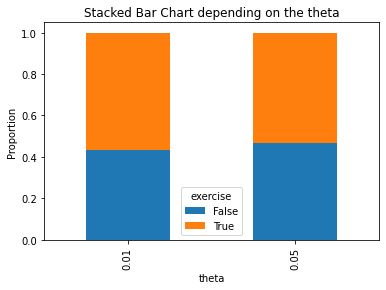

In [21]:
table = pd.crosstab(df2.theta, df2.exercise)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart depending on the theta')
plt.xlabel('theta')
plt.ylabel('Proportion');

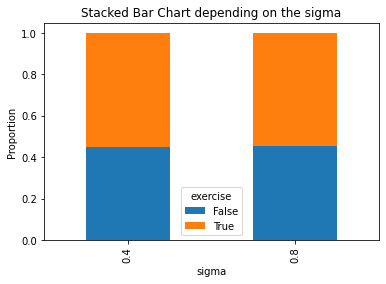

In [23]:
table = pd.crosstab(df2.sigma, df2.exercise)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart depending on the sigma')
plt.xlabel('sigma')
plt.ylabel('Proportion');

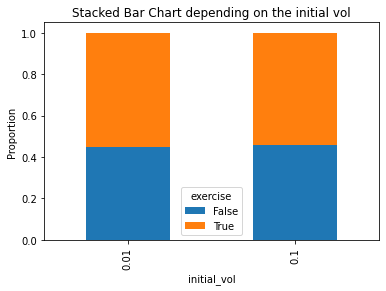

In [24]:
table = pd.crosstab(df2.initial_vol, df2.exercise)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart depending on the initial vol')
plt.xlabel('initial_vol')
plt.ylabel('Proportion');

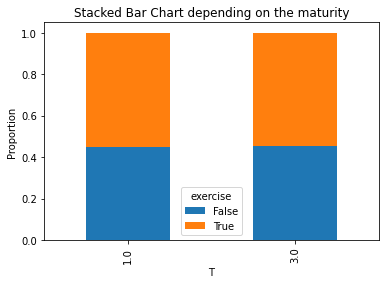

In [26]:
table = pd.crosstab(df2.maturity, df2.exercise)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart depending on the maturity')
plt.xlabel('T')
plt.ylabel('Proportion')
plt.savefig('e_vs_ne_strike')

#### Logistic Regression

In [37]:
X = df2.drop('exercise', axis = 1)
y = df2['exercise']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [34]:
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [38]:
logreg2 = LogisticRegression()
logreg2.fit(X_train, y_train)

LogisticRegression()

In [42]:
X.columns

Index(['stock_zero', 'sigma', 'maturity', 'initial_vol', 'kappa', 'rho',
       'theta'],
      dtype='object')

In [49]:
weights = logreg2.coef_
abs_weights = np.abs(weights).flatten()
abs_weights[-1]=0.05335492

print(f"Print Feature importance: \n")
for i in range(len(X.columns)):
    print(f"{X.columns[i]}: {abs_weights[i]}")

Print Feature importance: 

stock_zero: 3.3723396053896884
sigma: 0.06440089290982819
maturity: 0.009522686583890211
initial_vol: 0.3605304077959656
kappa: 0.015389850642859334
rho: 0.06372447910342552
theta: 0.05335492
